In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from xgboost import XGBClassifier

## Reading Data

In [3]:
# Reading shopping data
X_train = pd.read_csv('ShoppingData.csv')
df = X_train.copy()
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


## Producing dummy variables for categorical data and cleaning data

In [7]:
dummiesdf = pd.get_dummies(df['VisitorType'])
df.drop('VisitorType', inplace = True, axis = 1)
df['New_Visitor'] = dummiesdf['New_Visitor']
df['Other'] = dummiesdf['Other']
df['Returning_Visitor'] = dummiesdf['Returning_Visitor']

In [8]:
dfmonth = pd.get_dummies(df['Month']) 
df.drop('Month', inplace = True, axis = 1)
dfwithdummies = pd.concat([df, dfmonth], axis = 1, sort = False)

In [9]:
dfwithdummies['Class'] = df['Revenue'].astype(int)
dfwithdummies.drop('Revenue', axis = 1, inplace = True)
dfwithdummies['Weekend'] = df['Weekend'].astype(int)
dfwithdummies.drop('Returning_Visitor', axis = 1, inplace = True)
dfcleaned = dfwithdummies.copy()

In [10]:
X = dfcleaned.drop('Class', axis = 1)
Y = dfcleaned['Class'].copy()

## Checking for Collinearity Between Features and Creating Reducing Feature Size

In [11]:
cor = X.corr()

<Axes: >

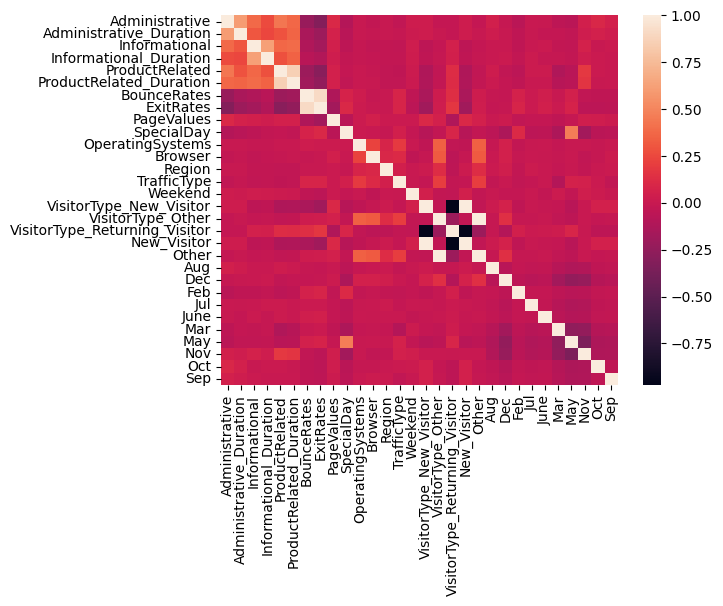

In [12]:
sns.heatmap(cor, xticklabels=cor.columns,yticklabels=cor.columns)

In [13]:
def AvgMinutes(Count, Duration):
    if Duration == 0:
        output = 0
    elif Duration != 0:
        output = float(Duration)/float(Count)
    return output
    
Columns = [['Administrative', 'Administrative_Duration'], ['Informational', 'Informational_Duration'], ['ProductRelated', 'ProductRelated_Duration']]
    
    
X['AvgAdministrative'] = X.apply(lambda x: AvgMinutes(Count = x['Administrative'], Duration = x['Administrative_Duration']), axis = 1)
X['AvgInformational'] = X.apply(lambda x: AvgMinutes(Count = x['Informational'], Duration = x['Informational_Duration']), axis = 1)
X['AvgProductRelated'] = X.apply(lambda x: AvgMinutes(Count = x['ProductRelated'], Duration = x['ProductRelated_Duration']), axis = 1)
X.drop(['Administrative', 'Administrative_Duration','Informational', 'Informational_Duration','ProductRelated', 'ProductRelated_Duration'], axis = 1, inplace = True)
#avg duration and creates a new column for each and then drops the original column

<Axes: >

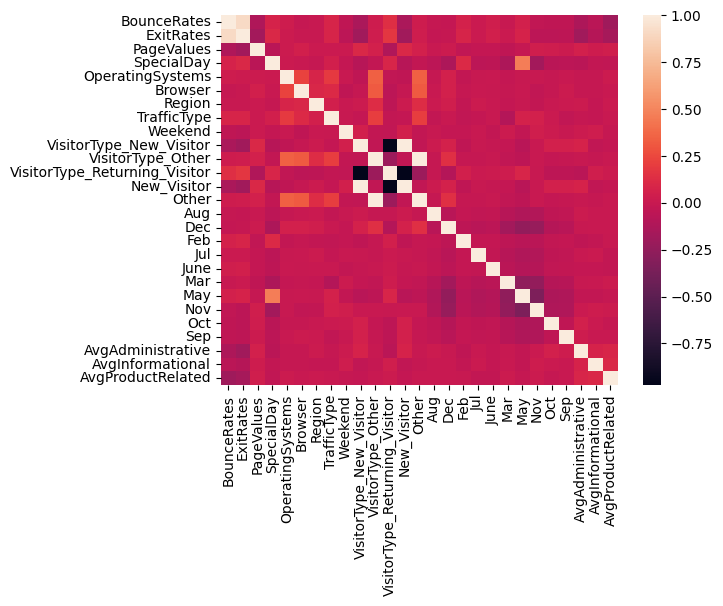

In [14]:
cor = X.corr()
sns.heatmap(cor, xticklabels=cor.columns,yticklabels=cor.columns)

## Quick overview of features

ValueError: hist method requires numerical or datetime columns, nothing to plot.

<Figure size 640x480 with 0 Axes>

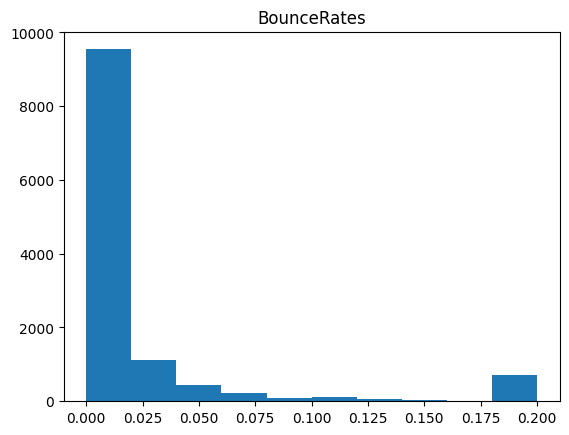

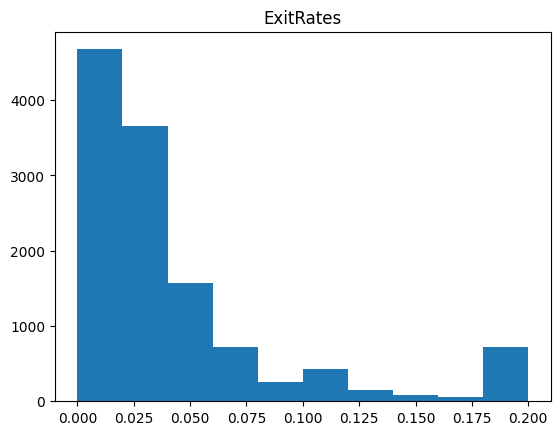

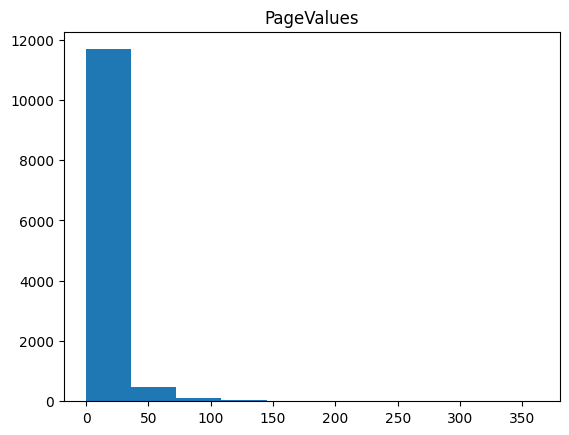

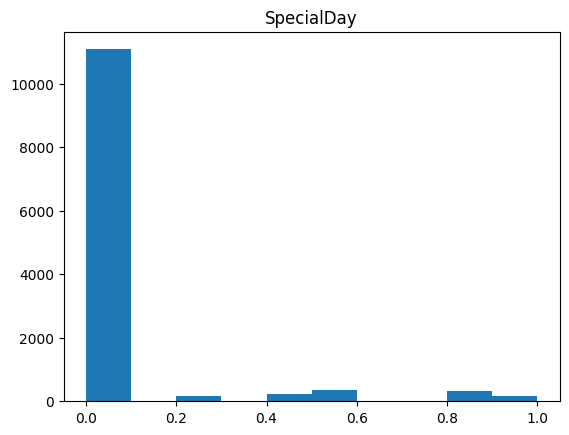

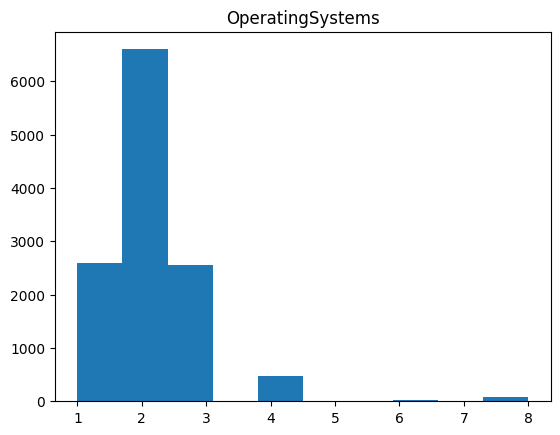

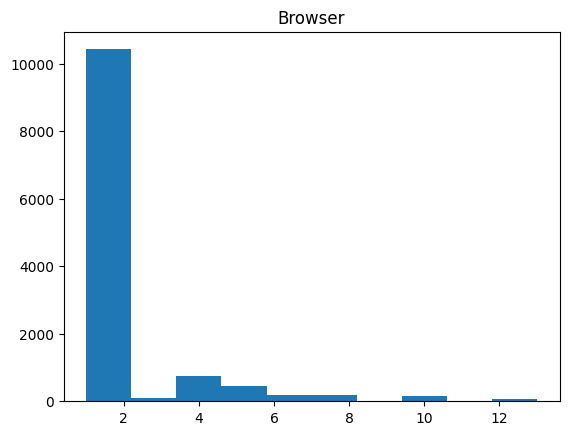

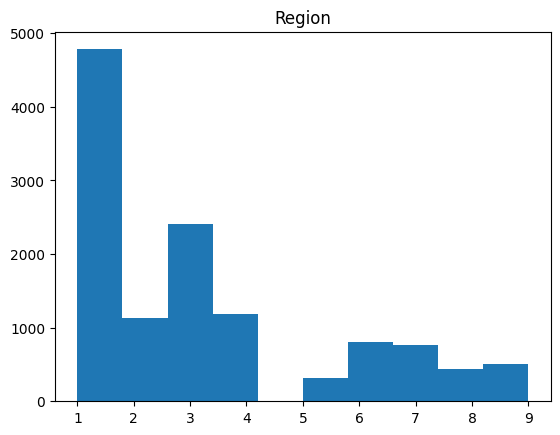

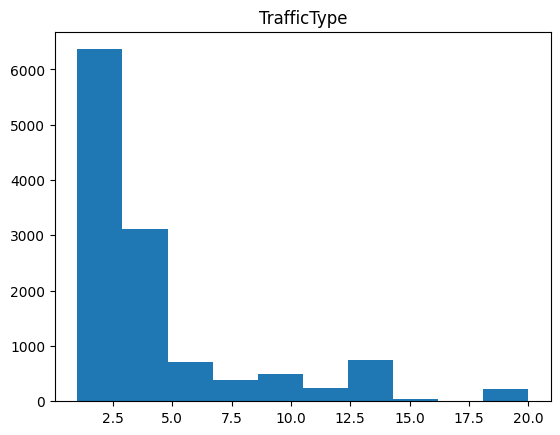

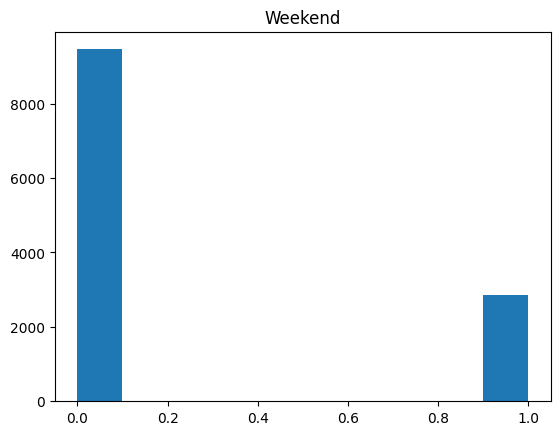

In [45]:
# Histogram of all features
for idx,column in enumerate(X.columns): 
    plt.figure(idx)
    X.hist(column=column,grid=False)

In [17]:
# Checking for NA values
for i in X.columns:
    print('Feature:',i)
    print('# of N/A:',X[i].isna().sum())

Feature: BounceRates
# of N/A: 0
Feature: ExitRates
# of N/A: 0
Feature: PageValues
# of N/A: 0
Feature: SpecialDay
# of N/A: 0
Feature: OperatingSystems
# of N/A: 0
Feature: Browser
# of N/A: 0
Feature: Region
# of N/A: 0
Feature: TrafficType
# of N/A: 0
Feature: Weekend
# of N/A: 0
Feature: VisitorType_New_Visitor
# of N/A: 0
Feature: VisitorType_Other
# of N/A: 0
Feature: VisitorType_Returning_Visitor
# of N/A: 0
Feature: New_Visitor
# of N/A: 0
Feature: Other
# of N/A: 0
Feature: Aug
# of N/A: 0
Feature: Dec
# of N/A: 0
Feature: Feb
# of N/A: 0
Feature: Jul
# of N/A: 0
Feature: June
# of N/A: 0
Feature: Mar
# of N/A: 0
Feature: May
# of N/A: 0
Feature: Nov
# of N/A: 0
Feature: Oct
# of N/A: 0
Feature: Sep
# of N/A: 0
Feature: AvgAdministrative
# of N/A: 0
Feature: AvgInformational
# of N/A: 0
Feature: AvgProductRelated
# of N/A: 0


In [18]:
for i in X_train.columns:
    print()
    print('COLUMN TITLE:',i)
    print('# UNIQUE VALUES:',len(X_train[i].unique()))
    print('UNIQUE VALUES:',X_train[i].unique())
    print()


COLUMN TITLE: Administrative
# UNIQUE VALUES: 27
UNIQUE VALUES: [ 0  1  2  4 12  3 10  6  5  9  8 16 13 11  7 18 14 17 19 15 24 22 21 20
 23 27 26]


COLUMN TITLE: Administrative_Duration
# UNIQUE VALUES: 3335
UNIQUE VALUES: [  0.         53.         64.6       ... 167.9107143 305.125
 150.3571429]


COLUMN TITLE: Informational
# UNIQUE VALUES: 17
UNIQUE VALUES: [ 0  1  2  4 16  5  3 14  6 12  7  9 10  8 11 24 13]


COLUMN TITLE: Informational_Duration
# UNIQUE VALUES: 1258
UNIQUE VALUES: [  0.   120.    16.   ... 547.75 368.25 211.25]


COLUMN TITLE: ProductRelated
# UNIQUE VALUES: 311
UNIQUE VALUES: [  1   2  10  19   0   3  16   7   6  23  13  20   8   5  32   4  45  14
  52   9  46  15  22  11  12  36  42  27  90  18  38  17 128  25  30  21
  51  26  28  31  24  50  96  49  68  98  67  55  35  37  29  34  71  63
  87  40  33  54  64  75  39 111  81  61  47  44  88 149  41  79  66  43
 258  80  62  83 173  48  58  57  56  69  82  59 109 287  53  84  78 137
 113  89  65  60 104 129 

C:\Users\KIIT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\plotting\_matplotlib\tools.py:224: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(**fig_kw)


<Figure size 640x480 with 0 Axes>

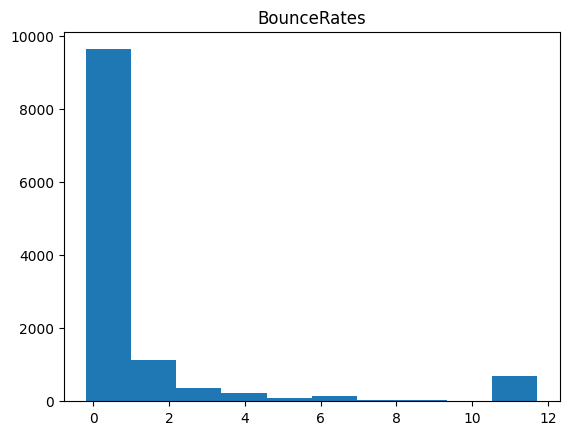

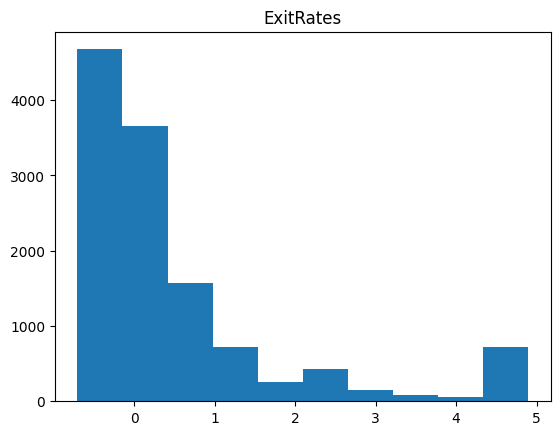

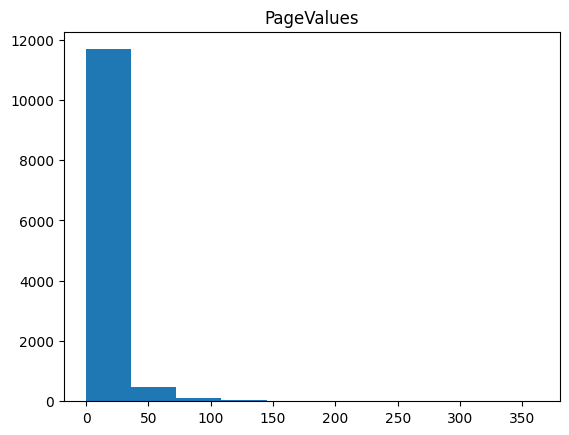

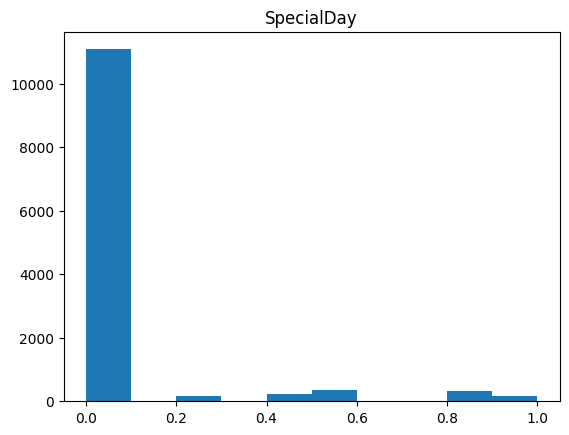

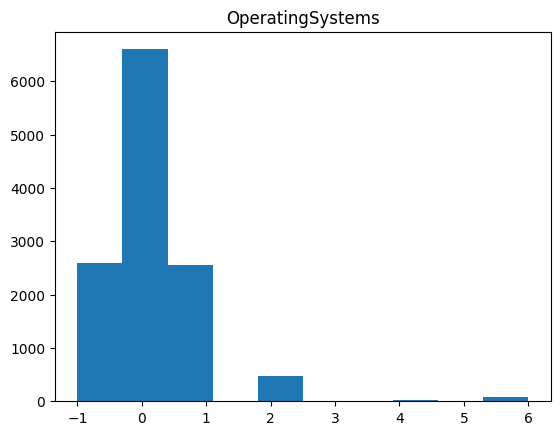

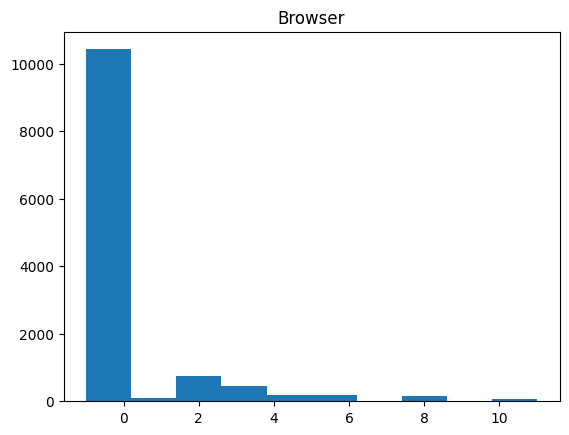

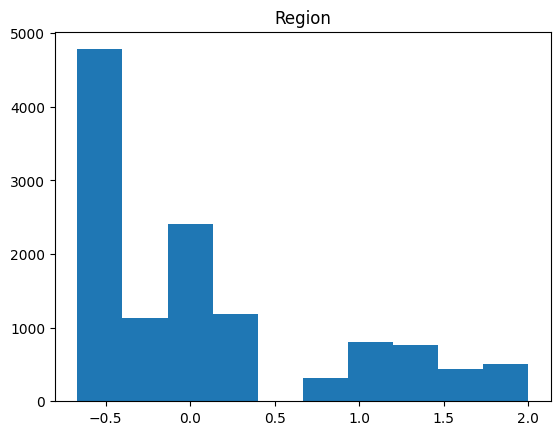

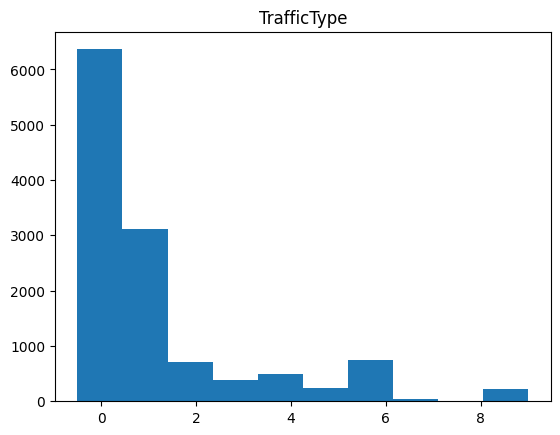

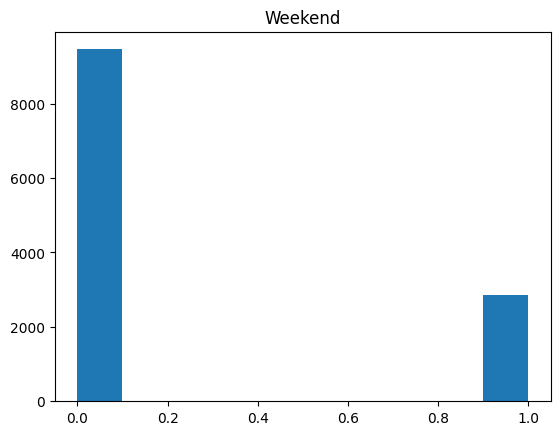

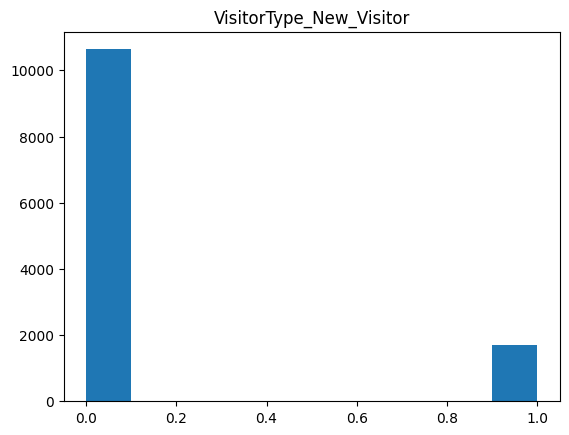

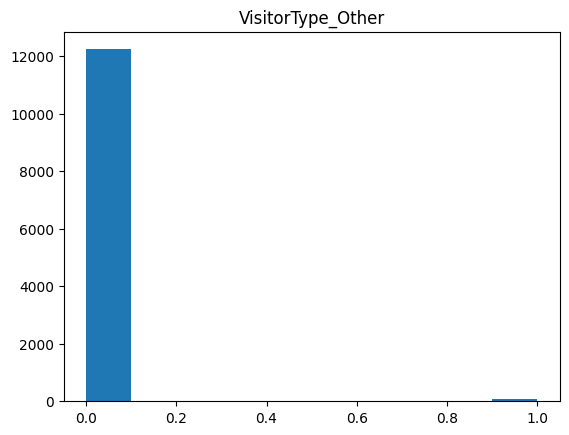

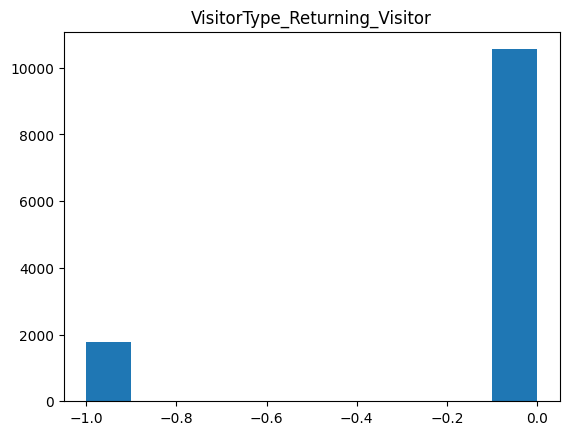

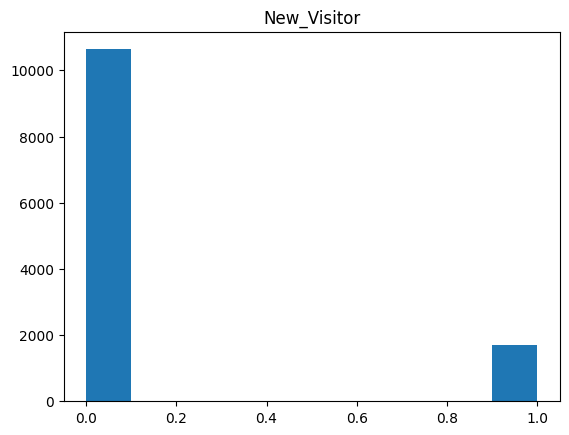

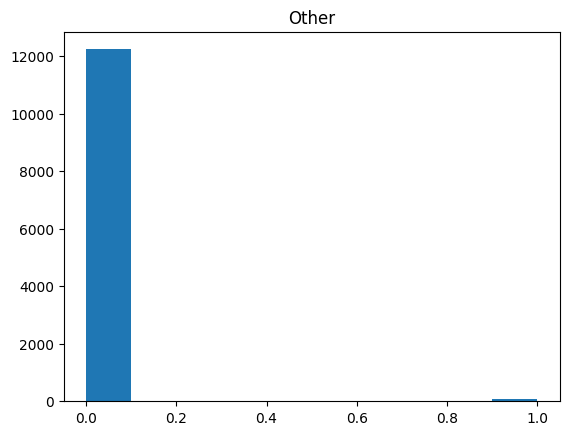

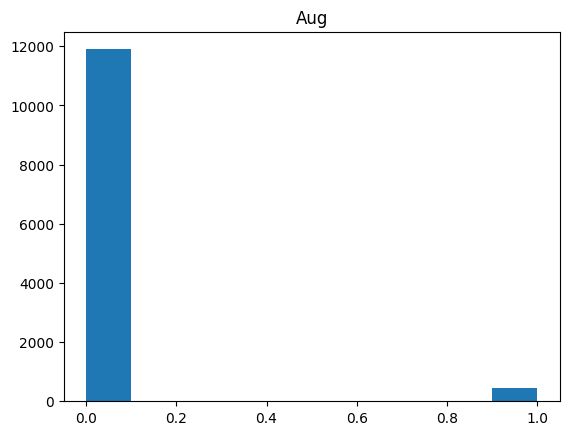

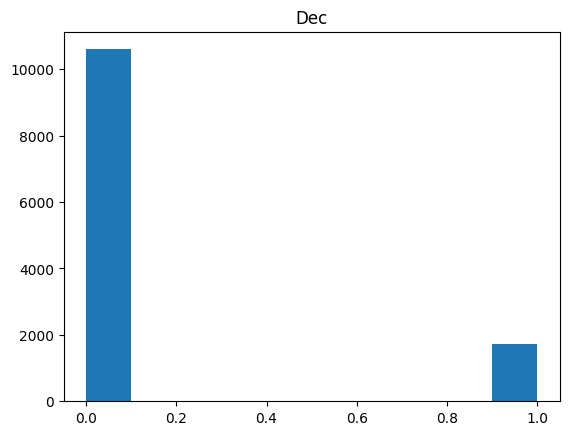

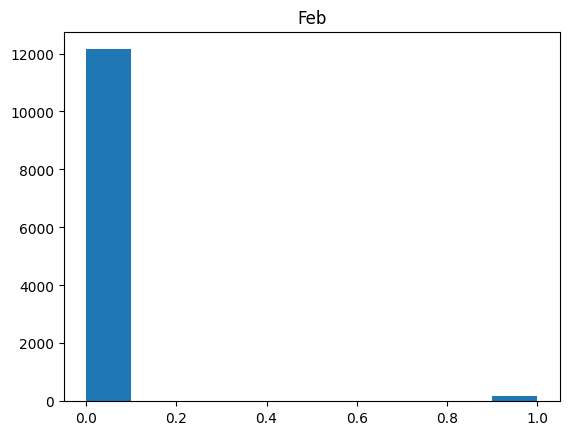

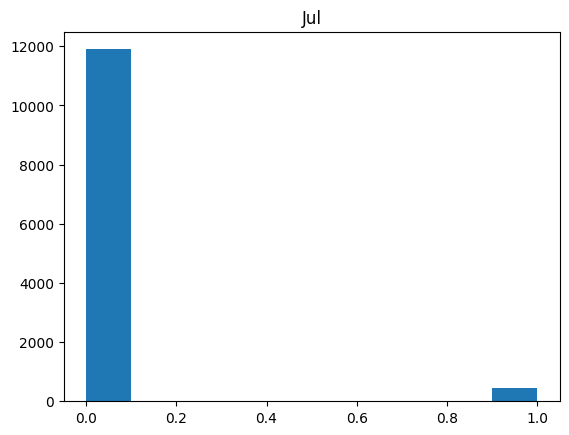

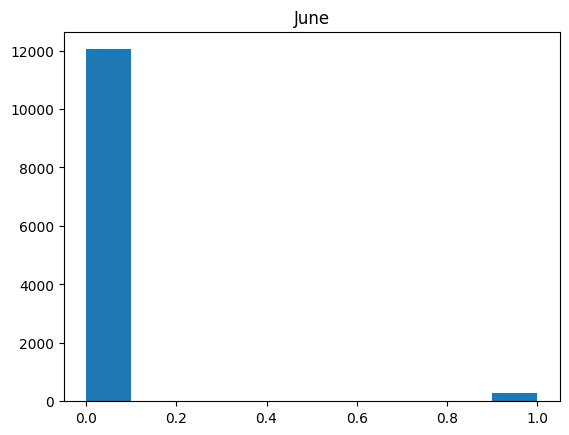

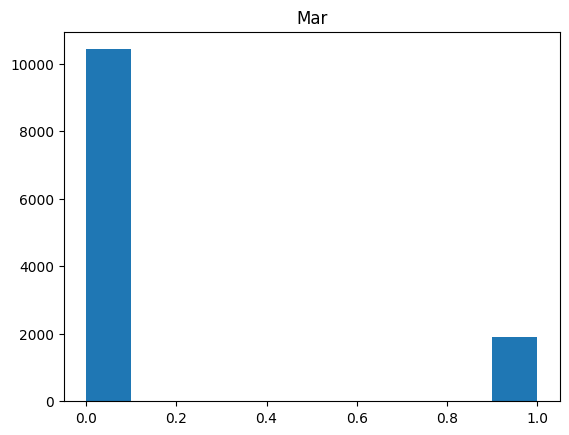

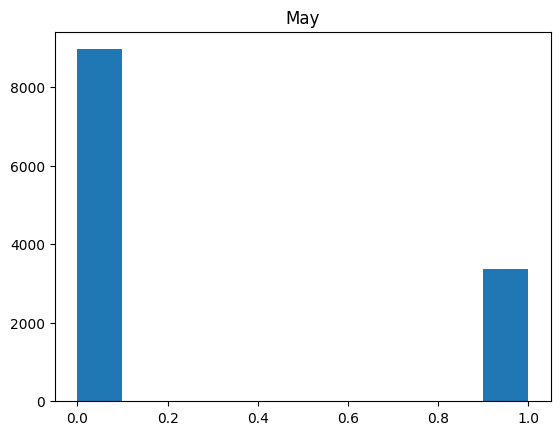

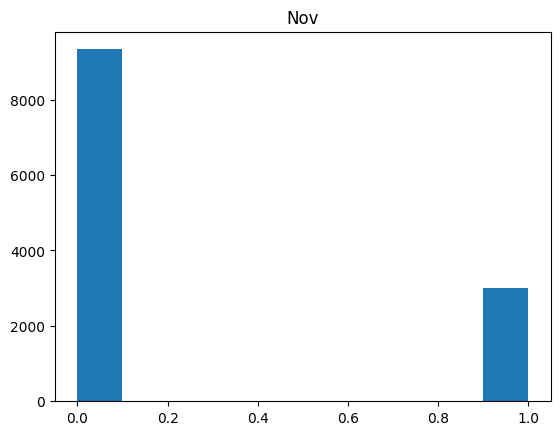

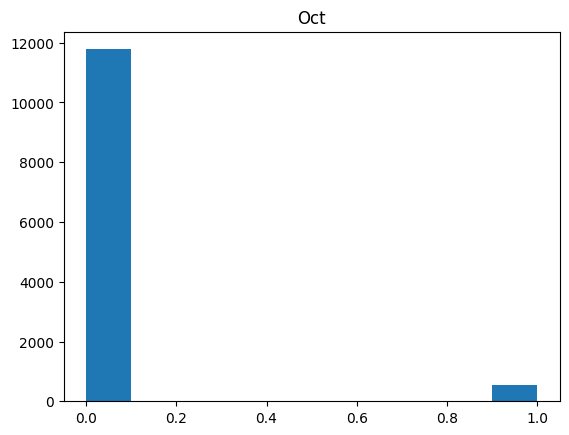

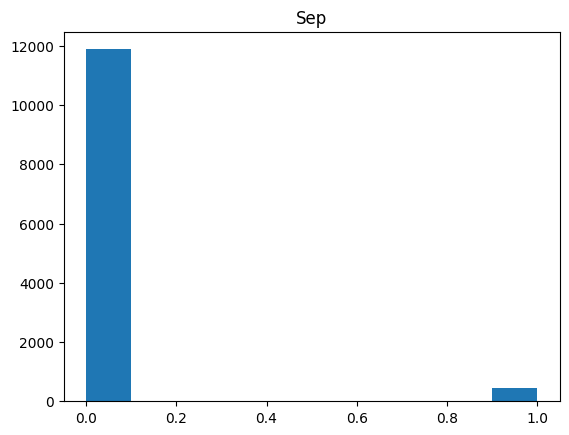

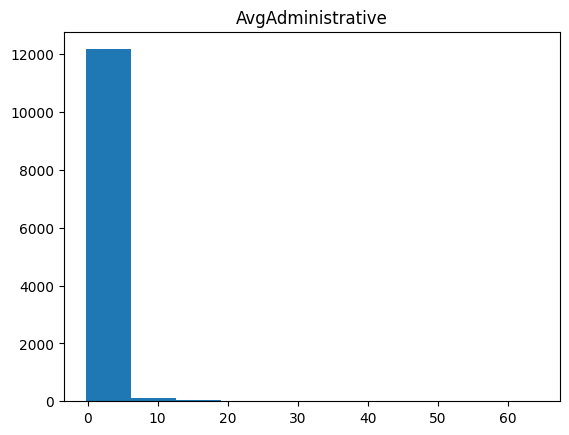

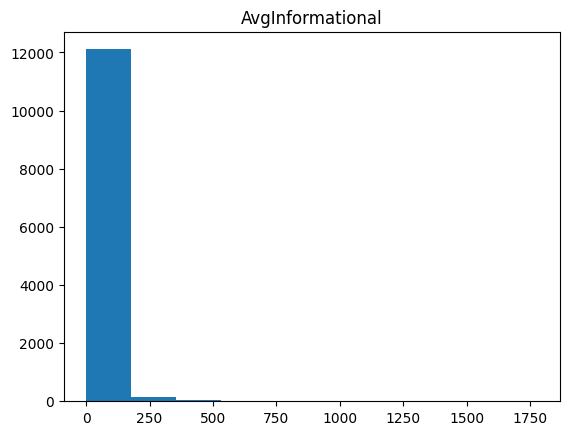

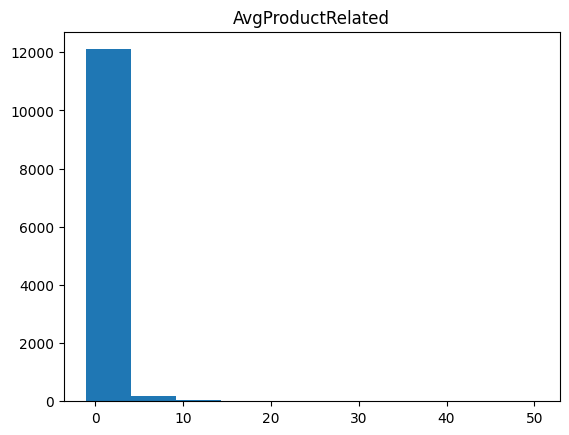

In [20]:
# Scaling to normalize data
X_copy = X.copy()
rc = RobustScaler()
X_rc=rc.fit_transform(X_copy)
X_rc=pd.DataFrame(X_rc,columns=X.columns)

for idx,column in enumerate(X_rc.columns):
    plt.figure(idx)
    X_rc.hist(column=column,grid=False)

## Linear Model with All Features

In [21]:
from sklearn import linear_model
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X_rc,Y,test_size=.2)

In [37]:
# Linear model
model = linear_model.SGDClassifier()
model.fit(X_train, y_train)

SGDClassifier()

In [38]:
y_pred = model.predict(X_test)

In [39]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.7923763179237632

In [40]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred)

0.7928306461640485

In [41]:
from sklearn.metrics import mean_absolute_error
prediction = model.predict(X_test)
print("Mean Absolute Error test data : " + str(mean_absolute_error(prediction, y_test)))

Mean Absolute Error test data : 0.20762368207623683


In [42]:
model.score(X_train,y_train)

0.7805150040551501

In [43]:
model.score(X_test,y_test)

0.7923763179237632

#### Test score is greater than Training score so the model can be used as Generalised model for the datasets